<a href="https://colab.research.google.com/github/kelvinsima2/Environmental_Audio_Classification/blob/main/Environmental_Sound_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries

import numpy as np 
import pandas as pd 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import os, random, librosa
from tqdm.auto import tqdm
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from keras.preprocessing.image import ImageDataGenerator
sns.set_style('darkgrid')

import os
import matplotlib.pylab as plt

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

# Converting Audio Files Into Mel Spectograms

In [ ]:
def read_and_pad_sound_wave(filepath, audio_length=(44100*5)):
    waveform, sr = sf.read(filepath)
    zero_padding = np.zeros([audio_length - len(waveform)])
    waveform = np.concatenate([waveform, zero_padding], 0)
    return waveform, sr
    # uncomment below for wavelet transfrom only
    # return waveform 

def sound_wave_to_mel_spectrogram(sound_wave, sample_rate, spec_h=128, spec_w=128, length=1):
    NUM_MELS = spec_h
    HOP_LENGTH = int(sample_rate * length / (spec_w - 1)) 
    mel_spec = librosa.feature.melspectrogram(y=sound_wave, sr=sample_rate, hop_length=HOP_LENGTH, n_mels=NUM_MELS)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    return mel_spec_db




In [ ]:
# uncomment to define wavelet transform function. In this notebook, mel spectograms are used instead

# from scipy import signal
# def make_cwts(waveform):
#   widths = np.arange(1,100)
#   cwtmatr = signal.cwt(waveform, signal.ricker, widths)
#   cwtmatr_yflip = np.flipud(cwtmatr)
#   return cwtmatr, cwtmatr_yflip
# filepath = os.path.join(input_dir, parent_list[2])
# waveform, sr = sf.read(filepath)
# cwtmatr, cwtmatr_yflip = make_cwts(waveform)
# fig = plt.subplots(figsize=(8, 7))
# img = plt.imshow(cwtmatr_yflip,extent=[0, 5, 1, 20], cmap='plasma', aspect='auto',
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
# plt.axis('off')

In [ ]:
# define file paths
input_dir = '/content/drive/My Drive/Environmental Project/Audio/44100/'
output_dir = '/content/drive/My Drive/Environmental Project/Output/'
output_dir_wavelets = '/content/drive/My Drive/Environmental Project/Output-Wavelets/'

In [ ]:
# display some file names
parent_list = os.listdir(input_dir)
for i in range(10):
    print(parent_list[i])

3-152020-B-36.wav
3-152997-A-26.wav
3-154439-A-17.wav
3-154378-A-30.wav
3-152039-A-3.wav
3-151269-A-35.wav
3-154758-A-44.wav
3-151273-A-35.wav
3-151255-A-28.wav
3-152912-A-26.wav


In [ ]:
SIZE = 256
BATCH_SIZE = 32

for filename in tqdm(os.listdir(input_dir)):
    if "wav" in filename:
        file_path = os.path.join(input_dir, filename)
        target_dir = 'class_' + filename[:-4].split('-')[3]             
        dist_dir = os.path.join(output_dir, target_dir)
        file_dist_path = os.path.join(dist_dir, filename)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)                
            S_db_mel = sound_wave_to_mel_spectrogram(*read_and_pad_sound_wave(file_path))
            fig, ax = plt.subplots(figsize=(10, 5))
            # Plot the mel spectogram
            img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
            plt.axis('off')
            fig.savefig(f'{file_dist_path}.png', dpi=fig.dpi)
            plt.close()


# for filename in tqdm(os.listdir(input_dir)):
#     if "wav" in filename:
#         file_path = os.path.join(input_dir, filename)
#         target_dir = 'class_' + filename[:-4].split('-')[3]             
#         dist_dir = os.path.join(output_dir_wavelets, target_dir)
#         file_dist_path = os.path.join(dist_dir, filename)
#         if not os.path.exists(file_dist_path + '.png'):
#             if not os.path.exists(dist_dir):
#                 os.mkdir(dist_dir)     
#             waveform = read_and_pad_sound_wave(file_path)           
#             cwtmatr, cwtmatr_yflip = make_cwts(waveform)
#             fig = plt.subplots(figsize=(8, 7))
#             img = plt.imshow(cwtmatr_yflip,extent=[0, 5, 1, 10], cmap='plasma', aspect='auto',
#                   vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
#             plt.axis('off')
#             plt.savefig(f'{file_dist_path}.png')
#             plt.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

# Split Data into Training, Validation and Test Sets

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=output_dir,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(SIZE, SIZE),
                                             subset="training",
                                             seed=0,
                                             label_mode = 'categorical');

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=output_dir,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(SIZE, SIZE),
                                             subset="validation",
                                             seed=0,
                                             label_mode = 'categorical');

Found 2000 files belonging to 50 classes.
Using 1600 files for training.
Found 2000 files belonging to 50 classes.
Using 400 files for validation.


In [ ]:
# Obtain class names from training data. It is worth noting that they are presented in alphabetical order. This is useful during model testing.
class_names = train_dataset.class_names

In [ ]:
# Display shape of training set
train_dataset.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 50), dtype=tf.float32, name=None))

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 2


In [ ]:
# Use buffered prefetching to load images from disk without having I/O become blocking. This improves performance.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Model Development and Evaluation

In [ ]:
# Use the inception preprocessing function to rescale pixel values
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
# Create the base model from the pre-trained model Inception V3
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
base_model.trainable=False

# Create Tensorflow functional model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.BatchNormalization(renorm=True)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(150, activation='relu')(x)
# The output layer has 50 outputs representing the number of classes in the image dataset.
outputs = tf.keras.layers.Dense(50, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Get model summary
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_13 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_13 (TFOpLa  (None, 256, 256, 3)      0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 batch_normalization_1329 (B  (None, 6, 6, 2048)       14336     
 atchNormalization)                                              
                                                          

In [ ]:
# early stopping call back
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [ ]:
# Train model using GPU
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks = [early])

Epoch 1/10
50/50 [==============================] - 9s 77ms/step - loss: 3.6604 - accuracy: 0.1163 - val_loss: 2.6785 - val_accuracy: 0.3155
Epoch 2/10
50/50 [==============================] - 3s 46ms/step - loss: 2.2382 - accuracy: 0.4094 - val_loss: 2.0802 - val_accuracy: 0.4167
Epoch 3/10
50/50 [==============================] - 3s 46ms/step - loss: 1.5621 - accuracy: 0.5844 - val_loss: 1.8081 - val_accuracy: 0.4911
Epoch 4/10
50/50 [==============================] - 3s 47ms/step - loss: 1.1900 - accuracy: 0.6831 - val_loss: 1.6856 - val_accuracy: 0.5179
Epoch 5/10
50/50 [==============================] - 3s 47ms/step - loss: 0.9162 - accuracy: 0.7681 - val_loss: 1.5478 - val_accuracy: 0.5714
Epoch 6/10
50/50 [==============================] - 3s 46ms/step - loss: 0.7228 - accuracy: 0.8200 - val_loss: 1.5277 - val_accuracy: 0.5923
Epoch 7/10
50/50 [==============================] - 3s 46ms/step - loss: 0.5835 - accuracy: 0.8581 - val_loss: 1.5066 - val_accuracy: 0.5982
Epoch 8/10
50

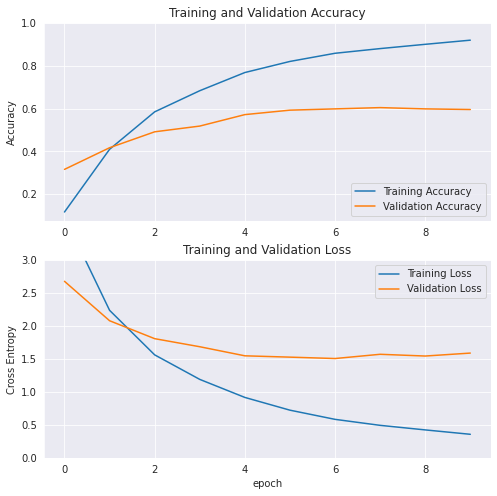

In [ ]:
# Plot accuracy and loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_dataset)

2/2 [==============================] - 0s 33ms/step - loss: 1.7358 - accuracy: 0.5938
